C:\Users\SIUUI\AppData\Local\Temp\ipykernel_4344\2488071862.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='c

✅ 成功加载模型: fashion_model.pth
图片处理成功！
处理后 Tensor 形状: torch.Size([1, 28, 28])

🎉 预测结果: 【T-shirt/top】


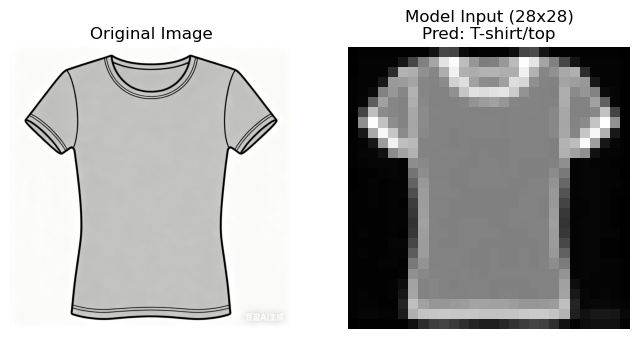

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# ==========================================
# 1. 重新定义模型结构 (必须与训练时完全一致)
# ==========================================
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# ==========================================
# 2. 加载训练好的模型
# ==========================================
model = Net()
model_path = "fashion_model.pth" # 确保这个文件在当前目录下

try:
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    print(f"✅ 成功加载模型: {model_path}")
except FileNotFoundError:
    print(f"❌ 错误: 找不到模型文件 '{model_path}'。请先运行训练代码。")
    exit()

model.eval() # 切换到推理模式

# ==========================================
# 3. 定义针对真实图片的预处理流程 (核心关键！)
# ==========================================
# FashionMNIST是黑底白图，真实图片通常是白底黑图，必须反色
real_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # 1. 转为灰度图
    transforms.Resize((28, 28)),                 # 2. 强制缩放到 28x28
    transforms.ToTensor(),                       # 3. 转为 Tensor (0.0-1.0)
    # 4. 颜色反转：用 1.0 减去像素值，白变黑，黑变白
    transforms.Lambda(lambda x: 1.0 - x),        
    # 5. 归一化 (使用训练时的参数)
    transforms.Normalize((0.2860,), (0.3530,))   
])

# ==========================================
# 4. 读取并处理你的图片
# ==========================================
image_path = "duanxiu.png" # 确保你的图片名是这个
try:
    # 打开原始图片
    original_image = Image.open(image_path)
    # 应用预处理
    processed_image_tensor = real_image_transform(original_image)
    
    print("图片处理成功！")
    print(f"处理后 Tensor 形状: {processed_image_tensor.shape}") # 应该是 [1, 28, 28]

except FileNotFoundError:
    print(f"❌ 错误: 找不到图片文件 '{image_path}'。请检查文件名和路径。")
    exit()

# ==========================================
# 5. 进行预测
# ==========================================
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

with torch.no_grad():
    # 增加一个批次维度 [1, 28, 28] -> [1, 1, 28, 28]
    input_batch = processed_image_tensor.unsqueeze(0)
    # 模型推理
    outputs = model(input_batch)
    # 获取概率最大的类别索引
    predicted_idx = outputs.argmax(1).item()
    predicted_label = classes[predicted_idx]

print(f"\n🎉 预测结果: 【{predicted_label}】")

# ==========================================
# 6. 可视化对比 (左边是你的原图，右边是喂给模型的图)
# ==========================================
plt.figure(figsize=(8, 4))

# 显示原图
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# 显示处理后喂给模型的图 (还原一下归一化以便显示)
plt.subplot(1, 2, 2)
# 简单的还原显示，不一定精确，但能看出是黑底白图
show_img = processed_image_tensor.squeeze().numpy()
plt.imshow(show_img, cmap='gray')
plt.title(f"Model Input (28x28)\nPred: {predicted_label}")
plt.axis('off')

plt.show()